In [1]:
import deepSI
import numpy as np
from casadi import *
from NonlinearController.model_utils import *
import time
import torch
from functorch import jacrev, jacfwd, vmap
import matplotlib.pyplot as plt
import copy as copy
import timeit

In [2]:
def lambda_trap(x0,u0,nx,nu,ny,Jfx,Jfu,Jhx,stages):
    # FUNCTION LAMBDA_SIMPSON
    # Simpson rule integrator between 0 and 1 with chosen resolution (stages)
    # used to get A,B matrices symbolically to be used at gridpoints
    
    A = np.zeros([nx,nx])
    B = np.zeros([nx,nu])
    C = np.zeros([ny,nx])
    lambda0 = 0
    dlam = 1/stages

    x = lambda lam: lam*x0
    u = lambda lam: lam*u0

    for i in np.arange(stages):
        A = A + dlam*1/2*(Jfx(x(lambda0), u(lambda0)) + Jfx(x(lambda0+dlam), u(lambda0+dlam)))
        B = B + dlam*1/2*(Jfu(x(lambda0), u(lambda0)) + Jfu(x(lambda0+dlam), u(lambda0+dlam)))
        C = C + dlam*1/2*(Jhx(x(lambda0), u(lambda0)) + Jhx(x(lambda0+dlam), u(lambda0+dlam)))
        lambda0 = lambda0 + dlam
            
    return A,B,C

def lambda_simpson(x,u,nx,nu,ny,Jfx,Jfu,Jhx,stages):
    # FUNCTION LAMBDA_SIMPSON
    # Simpson rule integrator between 0 and 1 with chosen resolution (stages)
    # used to get A,B matrices symbolically to be used at gridpoints
    
    A = np.zeros([nx,nx])
    B = np.zeros([nx,nu])
    C = np.zeros([ny,nx])
    lambda0 = 0
    dlam = 1/stages

    for i in np.arange(stages):
        A = A + dlam*1/6*(Jfx(lambda0*x,lambda0*u) + 4*Jfx((lambda0+dlam/2)*x,(lambda0+dlam/2)*u) + Jfx((lambda0+dlam)*x,(lambda0+dlam)*u))
        B = B + dlam*1/6*(Jfu(lambda0*x,lambda0*u) + 4*Jfu((lambda0+dlam/2)*x,(lambda0+dlam/2)*u) + Jfu((lambda0+dlam)*x,(lambda0+dlam)*u))
        C = C + dlam*1/6*(Jhx(lambda0*x,lambda0*u) + 4*Jhx((lambda0+dlam/2)*x,(lambda0+dlam/2)*u) + Jhx((lambda0+dlam)*x,(lambda0+dlam)*u))
        lambda0 = lambda0 + dlam
            
    return A,B,C


In [33]:
# model = deepSI.load_system("NonlinearController/trained_models/unbalanced/ObserverUnbalancedDisk_dt01_nab_4_SNR_30_e250")

nx = 2; n_nodes_per_layer = 50; n_hidden_layers = 2
net_params = {'n_nodes_per_layer':n_nodes_per_layer, 'n_hidden_layers':n_hidden_layers}
model = deepSI.fit_systems.SS_encoder_general(nx=nx, na=2*nx+1, nb=2*nx+1, na_right=1, \
                                            f_net_kwargs=net_params, h_net_kwargs=net_params, e_net_kwargs=net_params)
model.init_model(nu=nx//2, ny=nx//2)

n_stages = 1
Nc = 5
n_int_comp = 2
threads = 8

# declared sym variables
nx = model.nx
x = MX.sym("x",nx,1)
nu = model.nu if model.nu is not None else 1
u = MX.sym("u",nu,1)
ny = model.ny if model.ny is not None else 1

# convert torch nn to casadi function
x_rhs = CasADi_Fn(model, x, u)
f = Function('f', [x, u], [x_rhs])
y_rhs = CasADi_Hn(model, x)
h = Function('h', [x], [y_rhs])

correction_f = f(np.zeros((nx,1)), 0)
x_rhs_c = x_rhs - correction_f
correction_h = h(np.zeros((nx,1)))
y_rhs_c = y_rhs - correction_h

Jfx = Function("Jfx", [x, u], [jacobian(x_rhs_c,x)])
Jfu = Function("Jfu", [x, u], [jacobian(x_rhs_c,u)])
Jhx = Function("Jhx", [x, u], [jacobian(y_rhs_c,x)])

x0 = MX.sym("x0",nx,1)
u0 = MX.sym("u0",nu,1)

[A_sym, B_sym, C_sym] = lambda_trap(x0,u0,nx,nu,ny,Jfx,Jfu,Jhx,n_stages)
lpv_A = Function("get_A",[x0,u0],[A_sym])
lpv_B = Function("get_B",[x0,u0],[B_sym])
lpv_C = Function("get_C",[x0,u0],[C_sym])

lpv_A_Nc = lpv_A.map(Nc, "thread", threads)
lpv_B_Nc = lpv_B.map(Nc, "thread", threads)
lpv_C_Nc = lpv_C.map(Nc, "thread", threads)

In [34]:
Lambda = np.array([])
lambda0 = 0
dlam = 1/n_stages

for i in np.arange(n_stages):
    # Lambda = np.hstack((Lambda, lambda0, lambda0 + dlam/2, lambda0 + dlam)) # Simpson
    Lambda = np.hstack((Lambda, lambda0, lambda0 + dlam)) # Trapezium
    lambda0 = lambda0 + dlam

In [35]:
lpv_A_lam = Jfx.map(Nc*n_stages*n_int_comp, "thread", threads)
lpv_B_lam = Jfu.map(Nc*n_stages*n_int_comp, "thread", threads)
lpv_C_lam = Jhx.map(Nc*n_stages*n_int_comp, "thread", threads)

In [36]:
device_c = torch.device("cuda") 

JacF_c = vmap(jacrev(model.fn.to(device_c).float(), argnums=(0,1)))
JacH_c = vmap(jacrev(model.hn.to(device_c).float()))

model_cpu = copy.deepcopy(model)

device = torch.device("cpu") 
JacF = vmap(jacrev(model_cpu.fn.to(device).float(), argnums=(0,1)))
JacH = vmap(jacrev(model_cpu.hn.to(device).float()))

In [37]:
n_iter = 1000
torch.set_num_threads(threads)

func_total_time = 0.0
log_func_time = np.zeros(n_iter)

move_total_time = 0.0
log_move_time = np.zeros(n_iter)
back_total_time = 0.0
log_back_time = np.zeros(n_iter)
cuda_total_time = 0.0
log_cuda_time = np.zeros(n_iter)

cas_end_time = 0.0
stages_total_time = 0.0
log_stages_time = np.zeros(n_iter)

for i in range(n_iter):
    X = np.random.rand(nx,Nc)
    U = np.random.rand(nu,Nc)

    Xlam = np.kron(X, Lambda)
    Ulam = np.kron(U, Lambda)

    batch_size = Nc*n_stages*n_int_comp

    start_time = time.time()

    x = torch.reshape(torch.tensor(Xlam[np.newaxis].T, device=device),(batch_size,1,nx)).float()
    u = torch.reshape(torch.tensor(Ulam[np.newaxis].T, device=device),(batch_size,1,nu)).float()

    fA, fB = JacF(x,u)
    fC = JacH(x)

    fA_num = fA.detach()
    fB_num = fA.detach()
    fC_num = fA.detach()

    func_end_time = time.time()
    func_total_time += func_end_time - start_time
    log_func_time[i] = func_end_time - start_time

    start_time = time.time()

    x_c = torch.reshape(torch.tensor(Xlam[np.newaxis].T, device=device_c),(batch_size,1,nx)).float()
    u_c = torch.reshape(torch.tensor(Ulam[np.newaxis].T, device=device_c),(batch_size,1,nu)).float()

    move_end_time = time.time()
    move_total_time += move_end_time - start_time
    log_move_time[i] = move_end_time - start_time

    start_time = time.time()

    fA, fB = JacF_c(x_c,u_c)
    fC = JacH_c(x_c)

    cuda_end_time = time.time()
    cuda_total_time += cuda_end_time - start_time
    log_cuda_time[i] = cuda_end_time - start_time

    start_time = time.time()

    fA_num = fA.detach().cpu()
    fB_num = fA.detach().cpu()
    fC_num = fA.detach().cpu()

    back_end_time = time.time()
    back_total_time += back_end_time - start_time
    log_back_time[i] = back_end_time - start_time

    start_time = time.time()

    tA = lpv_A_lam(Xlam,Ulam)
    tB = lpv_B_lam(Xlam,Ulam)
    tC = lpv_C_lam(Xlam,Ulam)

    stages_end_time = time.time()
    stages_total_time += stages_end_time - start_time
    log_stages_time[i] = stages_end_time - start_time

# print("functorch: " + str(func_total_time))
# print("cuda: " + str(cuda_total_time))
# print("cuda total: " + str(cuda_total_time + move_total_time + back_total_time))
# print("CasADi stages: " + str(stages_total_time))

CasADi: 6.273877859115601
cpu: 3.711611032485962
cuda: 4.5886030197143555


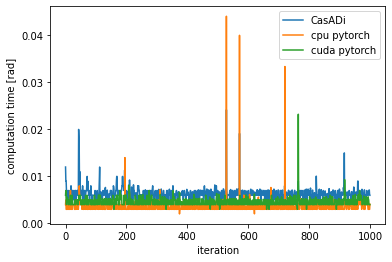

In [38]:
plt.plot(log_stages_time, label="CasADi")
plt.plot(log_func_time, label="cpu pytorch")
plt.plot(log_cuda_time + log_back_time + log_move_time, label="cuda pytorch")
plt.xlabel("iteration")
plt.ylabel("computation time [rad]")
# plt.ylim([0,0.05])
plt.legend()

print("CasADi: " + str(np.mean(log_stages_time)*1000))
print("cpu: " + str(np.mean(log_func_time)*1000))
print("cuda: " + str(np.mean(log_cuda_time + log_back_time + log_move_time)*1000))

CasADi: 6.730026483535767
cpu: 4.0611090660095215
cuda: 5.125952959060669


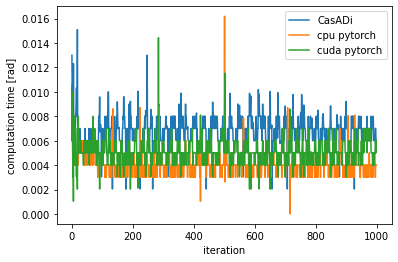

In [32]:
plt.plot(log_stages_time, label="CasADi")
plt.plot(log_func_time, label="cpu pytorch")
plt.plot(log_cuda_time + log_back_time + log_move_time, label="cuda pytorch")
plt.xlabel("iteration")
plt.ylabel("computation time [rad]")
# plt.ylim([0,0.05])
plt.legend()

print("CasADi: " + str(np.mean(log_stages_time)*1000))
print("cpu: " + str(np.mean(log_func_time)*1000))
print("cuda: " + str(np.mean(log_cuda_time + log_back_time + log_move_time)*1000))

Text(0, 0.5, 'computation time [rad]')

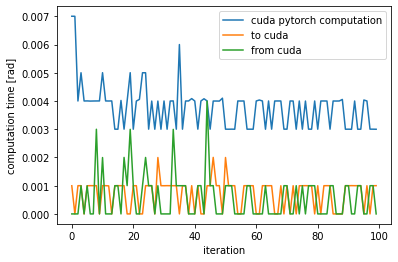

In [12]:
plt.plot(log_cuda_time, label="cuda pytorch computation")
plt.plot(log_move_time, label="to cuda")
plt.plot(log_back_time, label="from cuda")
plt.legend()
plt.xlabel("iteration")
plt.ylabel("computation time [rad]")

In [86]:
pA = lpv_A_Nc(X,U)
pB = lpv_B_Nc(X,U)
pC = lpv_C_Nc(X,U)

In [ ]:
n_iter = 5

list_A = np.zeros([Nc*nx, nx])
list_B = np.zeros([Nc*nx, nu])
list_C = np.zeros([Nc*ny, nx])

mult_A = np.stack((np.ones((nx,nx)), np.ones((nx,nx))*4, np.ones((nx,nx))))
mult_B = np.stack((np.ones((nx,nu)), np.ones((nx,nu))*4, np.ones((nx,nu))))
mult_C = np.vstack((np.ones((ny,nx)), np.ones((ny,nx))*4, np.ones((ny,nx))))

start_time = time.time()
for t in range(n_iter):

    for j in range(Nc):
        A = np.zeros((nx,nx))
        B = np.zeros([nx,nu])
        C = np.zeros((ny,nx))

        lambda0 = 0

        for i in range(n_stages):
            an = fA[n_int_comp*n_stages*j+(i)*n_int_comp:n_int_comp*n_stages*j+(i+1)*n_int_comp,0,:,0,:].detach().cpu().numpy()
            A = A + dlam*1/6*np.sum(np.multiply(mult_A, an), axis=0)

            bn = fB[n_int_comp*n_stages*j+(i)*n_int_comp:n_int_comp*n_stages*j+(i+1)*n_int_comp,0,:,0,:].detach().cpu().numpy()
            B = B + dlam*1/6*np.sum(np.multiply(mult_B, bn), axis=0)

            cn = fC[n_int_comp*n_stages*j+(i)*n_int_comp:n_int_comp*n_stages*j+(i+1)*n_int_comp,0,0,:].detach().cpu().numpy()
            # C = C + dlam*1/6*np.sum(np.multiply(mult_C, cn), axis=0)[np.newaxis]
            # above needs to be fixed

            lambda0 = lambda0 + dlam

        list_A[nx*(j):nx*(j+1),:] = A.copy()
        list_B[nx*(j):nx*(j+1),:] = B.copy()
        list_C[ny*(j):ny*(j+1),:] = C.copy()

end_time = time.time()
print("For Loops: " + str(end_time - start_time))


length_jac = n_stages*n_int_comp*Nc

mult_fA = torch.from_numpy(np.tile(np.vstack((np.ones((1,nx,nx)), 4*np.ones((1,nx,nx)), np.ones((1,nx,nx)))),(n_stages*Nc,1,1))).to(device)*dlam/6
mult_fB = torch.from_numpy(np.tile(np.vstack((np.ones((1,nx,nu)), 4*np.ones((1,nx,nu)), np.ones((1,nx,nu)))),(n_stages*Nc,1,1))).to(device)*dlam/6
mult_fC = torch.from_numpy(np.tile(np.vstack((np.ones((1,ny,nx)), 4*np.ones((1,ny,nx)), np.ones((1,ny,nx)))),(n_stages*Nc,1,1))).to(device)*dlam/6

list_fA = np.zeros([Nc*nx, nx])
list_fB = np.zeros([Nc*nx, nu])
list_fC = np.zeros([Nc*ny, nx])

start_time = time.time()

for t in range(n_iter):
    tempA = torch.tensor_split(torch.mul(fA.view((length_jac,nx,nx)), mult_fA).detach(), Nc)
    tempB = torch.tensor_split(torch.mul(fB.view((length_jac,nx,nu)), mult_fB).detach(), Nc)
    tempC = torch.tensor_split(torch.mul(fC.view((length_jac,ny,nx)), mult_fC).detach(), Nc)
    for i in range(Nc):
        list_fA[nx*(i):nx*(i+1),:] = torch.sum(tempA[i], axis=0).cpu().numpy()
        list_fB[nx*(i):nx*(i+1),:] = torch.sum(tempB[i], axis=0).cpu().numpy()
        list_fC[ny*(i):ny*(i+1),:] = torch.sum(tempC[i], axis=0).cpu().numpy()

end_time = time.time()
print("Torch short: " + str(end_time - start_time))

In [ ]:
np.allclose(list_A, list_fA), np.allclose(list_B, list_fB), np.allclose(list_C, list_fC)

In [ ]:
list_A_1 = np.zeros([Nc*nx, nx])
list_B_1 = np.zeros([Nc*nx, nx])
list_C_1 = np.zeros([Nc*ny, nx])
for i in range(Nc):
    list_A_1[(nx*i):(nx*i+nx),:] = pA[:,i*nx:(i+1)*nx]
for i in range(Nc):
    list_B_1[(nx*i):(nx*i+nx),:] = pB[:,i*nu:(i+1)*nu]
for i in range(Nc):
    list_C_1[(ny*i):(ny*i+ny),:] = pC[:,i*nx:(i+1)*nx]

In [ ]:
np.allclose(list_A_1, list_A), np.allclose(list_B_1, list_B), np.allclose(list_C_1, list_C)